In [3]:
import pandas as pd
import numpy as np
from scipy.stats import entropy
import sys,pickle,glob
from tqdm import tqdm_notebook as tq
from IPython.display import display
from nltk.corpus import stopwords
from nltk.stem.snowball import EnglishStemmer
from collections import Counter
from IPython.core.display import display
#from pathos import multiprocessing as mp

from matplotlib import pyplot as plt
import seaborn
colors = seaborn.color_palette()
xr_full = range(1991,2016)
xr = range(1992,2016)
%matplotlib inline

In [15]:
DATADIR = '../results/'
#DATADIR = '/Users/jaredlorince/Desktop/'
# files = glob.glob(DATADIR+'by-cat-results/results*')
# cats = set([f[f.rfind('_')+1:] for f in files])
# print(sorted(cats))

In [45]:
cat_pubs_by_year.head()

,Acoustics,Agricultural Economics & Policy,Agricultural Engineering,"Agriculture, Dairy & Animal Science","Agriculture, Multidisciplinary",Agronomy,Allergy,Anatomy & Morphology,Andrology,Anesthesiology,...,Transportation Science & Technology,Tropical Medicine,Urban Studies,Urology & Nephrology,Veterinary Sciences,Virology,Water Resources,Women's Studies,Zoology,ALL
1991,2432.0,915.0,777.0,4315.0,2687.0,6168.0,1613.0,1331.0,252.0,3758.0,...,532.0,1825.0,976.0,6190.0,9970.0,3920.0,3741.0,702.0,8683.0,901808
1992,2413.0,535.0,762.0,3857.0,2712.0,5365.0,2562.0,1454.0,253.0,3966.0,...,461.0,2003.0,844.0,7055.0,10208.0,4441.0,3923.0,769.0,7777.0,922010
1993,2537.0,942.0,750.0,3943.0,2428.0,5265.0,2826.0,1428.0,241.0,6457.0,...,487.0,1671.0,1053.0,7219.0,10563.0,4174.0,3907.0,922.0,7930.0,963477
1994,3117.0,980.0,762.0,3799.0,2703.0,5245.0,2957.0,1300.0,283.0,6684.0,...,575.0,1714.0,1137.0,10643.0,10449.0,5036.0,4405.0,1288.0,7647.0,1015818
1995,3254.0,999.0,770.0,3761.0,2598.0,5593.0,3231.0,1369.0,278.0,6887.0,...,570.0,1548.0,1468.0,11947.0,10420.0,4873.0,4964.0,1475.0,7910.0,1080336


In [44]:
cat_authors_by_year.head()

,Acoustics,Agricultural Economics & Policy,Agricultural Engineering,"Agriculture, Dairy & Animal Science","Agriculture, Multidisciplinary",Agronomy,Allergy,Anatomy & Morphology,Andrology,Anesthesiology,...,Transportation Science & Technology,Tropical Medicine,Urban Studies,Urology & Nephrology,Veterinary Sciences,Virology,Water Resources,Women's Studies,Zoology,ALL
1991,4736.0,1420.0,1613.0,8648.0,5670.0,12850.0,4185.0,3631.0,763.0,7698.0,...,841.0,5386.0,1103.0,17638.0,19290.0,12478.0,7037.0,831.0,16707.0,1257088
1992,4756.0,763.0,1566.0,8158.0,5982.0,10722.0,6453.0,3724.0,775.0,8417.0,...,893.0,5731.0,972.0,19955.0,20294.0,13909.0,7495.0,890.0,15587.0,1312601
1993,5157.0,1499.0,1627.0,8465.0,5797.0,10840.0,7283.0,3927.0,797.0,13498.0,...,801.0,5107.0,1292.0,20154.0,21090.0,13867.0,7794.0,1038.0,15811.0,1400893
1994,6122.0,1672.0,1694.0,8515.0,6247.0,11358.0,7795.0,3490.0,859.0,14861.0,...,1059.0,5441.0,1309.0,28999.0,21058.0,16592.0,8631.0,1357.0,15708.0,1481752
1995,6442.0,1744.0,1774.0,8468.0,6311.0,12631.0,8582.0,3767.0,831.0,15320.0,...,1091.0,5242.0,1767.0,32346.0,21392.0,16642.0,9855.0,1732.0,16813.0,1606585


In [38]:
cat_pubs_by_year = pd.read_pickle(DATADIR+'cat_pubs_by_year.pkl')
cat_citations_by_year = pd.read_pickle(DATADIR+'cat_citations_by_year.pkl')
cat_authors_by_year = pd.read_pickle(DATADIR+'cat_authors_by_year.pkl')

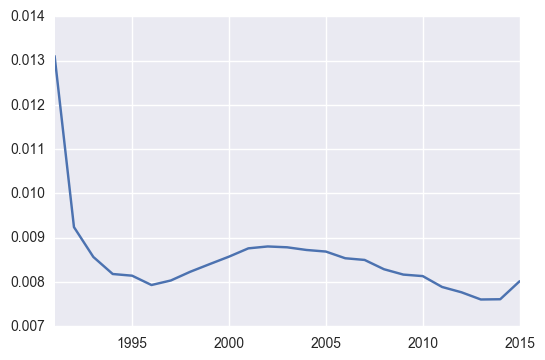

In [53]:
cat = 'Oncology'
#(cat_pubs_by_year[cat] / cat_pubs_by_year['ALL']).plot()
(cat_citations_by_year[cat] / cat_citations_by_year['ALL']).plot()
#(cat_authors_by_year[cat] / cat_authors_by_year['ALL']).plot()


In [6]:
props = cat_pubs_by_year.divide(cat_pubs_by_year['ALL'],axis=0)
growth = np.log10(props/props.shift(1))

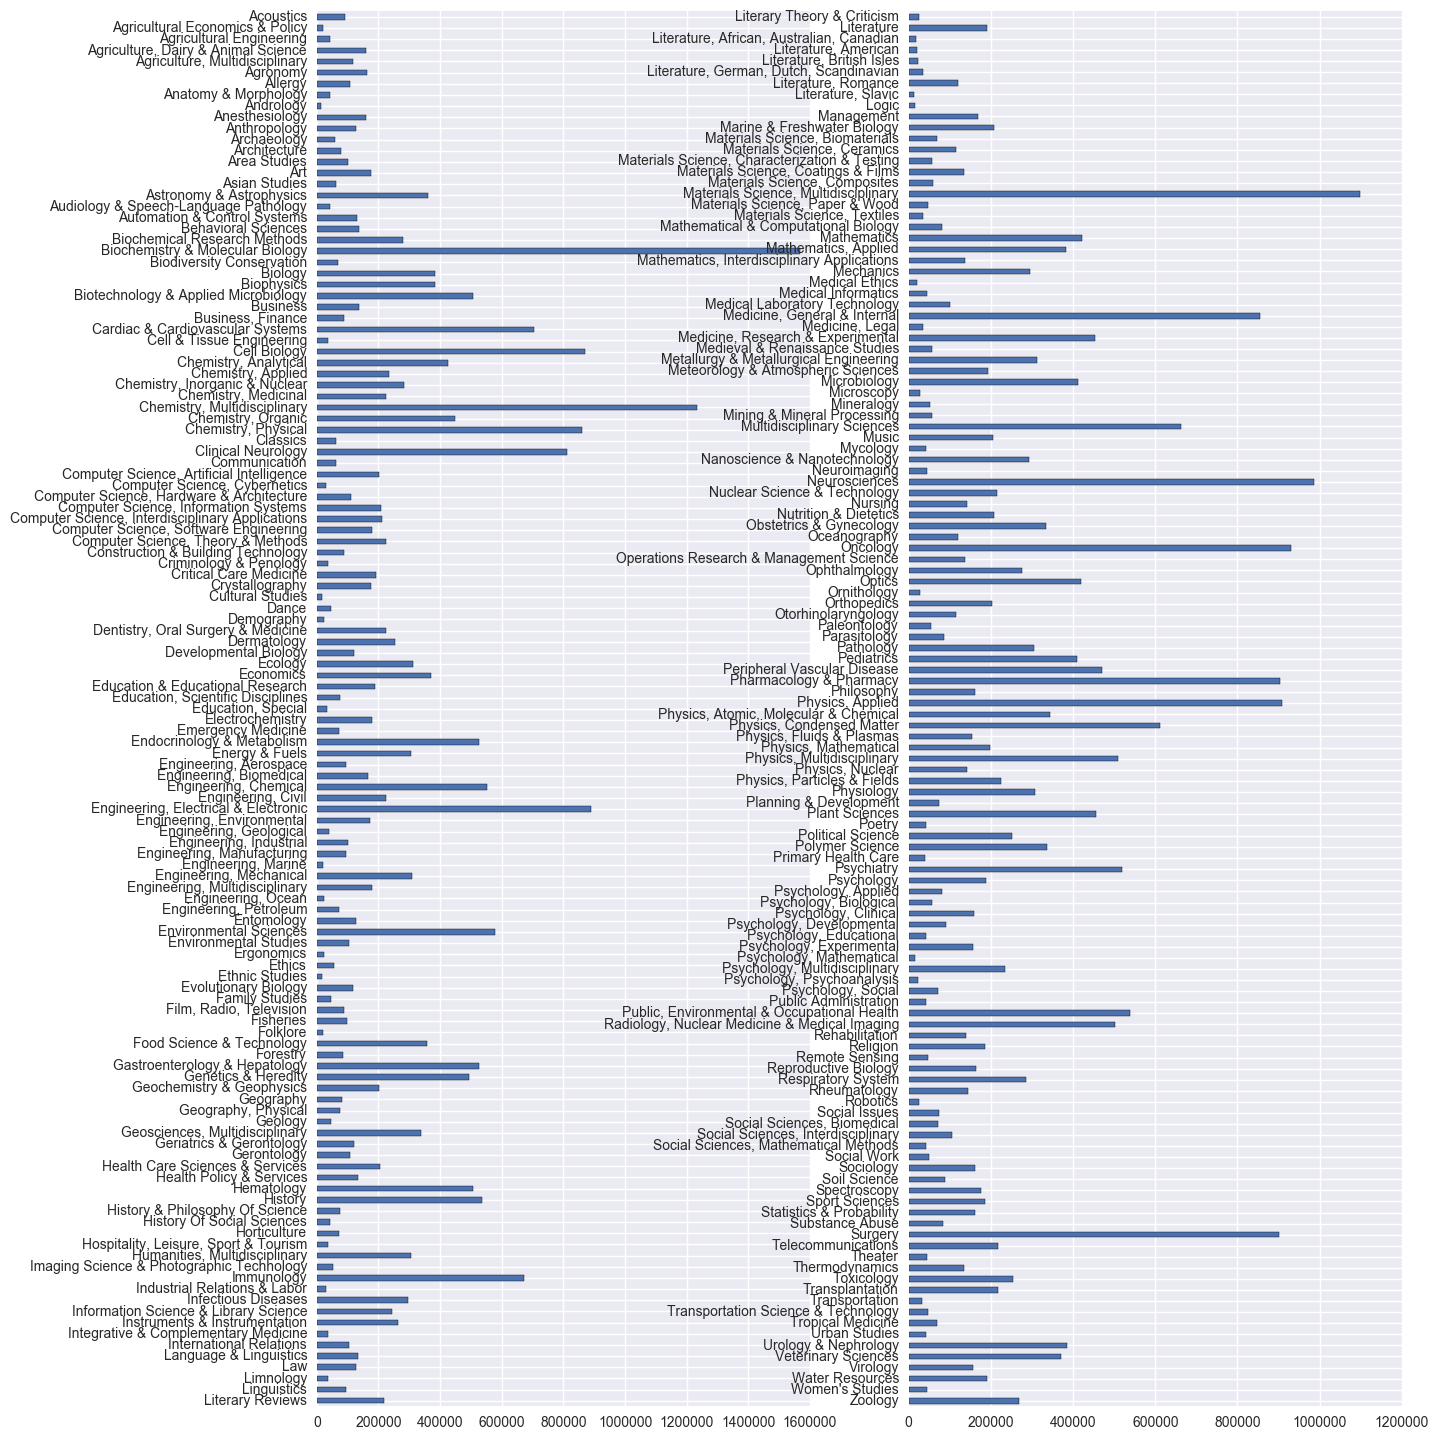

In [7]:
#just a big bar plot of the overall number of pubs for each field
fig,axes = plt.subplots(1,2,figsize=(14,18))
mx = cat_pubs_by_year.sum(0)[:-1].max()
cat_pubs_by_year.sum(0)[:125][::-1].plot(kind='barh',ax=axes[0],ylim=(0,mx))
cat_pubs_by_year.sum(0)[125:-1][::-1].plot(kind='barh',ax=axes[1],ylim=(0,mx));

In [8]:
def growth(cat,window):
    mx = len(cat_pubs_by_year)-(2*window-1)
    result = []
    for i in range(mx):
        a = cat_pubs_by_year[cat][i:i+window].sum()
        aprop = a/cat_pubs_by_year['ALL'][i:i+window].sum()
        b = cat_pubs_by_year[cat][i+window:i+window*2].sum()
        bprop = b/cat_pubs_by_year['ALL'][i+window:i+window*2].sum()
        result.append(np.log(bprop/aprop))    
    return np.array(result)

In [9]:
def parse_results(fi):
    df =  pd.read_table(fi,header=None,names=['measure','data'],index_col='measure')
    df.data = df.data.apply(lambda x: np.array(x.split(','),dtype=float))
    return df

In [16]:
colors = seaborn.color_palette()
def plotter(cat,window_size,mode='local'):
    #df = parse_results("{}by-cat-results/results_{}_{}".format(DATADIR,window_size,cat))
    df = parse_results("{}by-cat-results/{}_null/results_{}_{}".format(DATADIR,mode,window_size,cat))
    start = 1991+window_size-.5
    r = np.arange(start,start+len(df.ix['jsds'][0]))
    if window_size%2==0:
        r2 = np.arange(1991,1991+len(df.ix['ents'][0]))
    else:
        r2 = np.arange(start,start+len(df.ix['ents'][0]))

    fig,axes = plt.subplots(1,4,figsize=(16,4))
    
    ax = axes[0]
    ax.plot(r,df.ix['jsds'][0],label='JSD (raw)',color=colors[0])
    ax.plot(r,df.ix['ent_difs'][0],label=r'$\Delta H$ (raw)',color=colors[1])
    ax.plot(r,df.ix['jsd-null_m'][0],label='JSD (null)',c=colors[0],ls='--')
    ax.plot(r,df.ix['entdif-null_m'][0],label=r'$\Delta H$ (null)',color=colors[1],ls='--')
    #ax.fill_between(r,df.ix['entropy-null_m'][0]+df.ix['entropy-null_c'][0],df.ix['entropy-null_m'][0]-df.ix['entropy-null_c'][0],color=colors[1],alpha=.25)
    ax.axhline(0,c='k',ls='--')
    ax.set_xticks(np.arange(r[0]-.5,r[-1]+.5,5))
    ax.legend(loc='lower right',fontsize='medium')
    ax.set_title('Change measures')

    ax = axes[1]
    ax.plot(r2,df.ix['ents'][0],label='H (raw)')
    if mode == 'global':
        ax.plot(r2,df.ix['entropy-null_m'][0],label='H (null)',color=colors[1])
        ax.fill_between(r2,df.ix['entropy-null_m'][0]+df.ix['entropy-null_c'][0],df.ix['entropy-null_m'][0]-df.ix['entropy-null_c'][0],color=colors[1],alpha=.25)
    ax.set_title('Entropy')
    ax.legend(loc='lower right')
    
    ax = axes[2]
    ax.plot(r,growth(cat,window_size),label='Growth')
    ax.axhline(0,c='k',ls='--')
    ax.set_xticks(np.arange(r[0]-.5,r[-1]+.5,5))
    ax.set_title('Growth')
    
    ax = axes[3]
    ax.plot(r,df.ix['jsds'][0]-df.ix['jsd-null_m'][0],label='JSD (corrected)',color=colors[0])
    ax.plot(r,df.ix['ent_difs'][0]-df.ix['entdif-null_m'][0],label=r'$\Delta H$ (corrected)',color=colors[1])
    ax.legend(loc='upper right')
    ax.set_xticks(np.arange(r[0]-.5,r[-1]+.5,5))    
    ax.set_title('Corrected measures')
    
    fig.suptitle(cat)
    

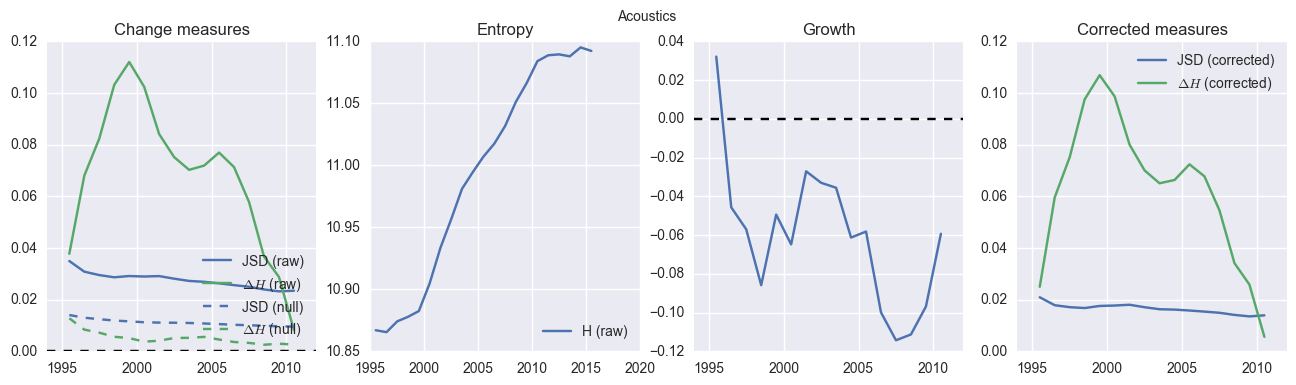

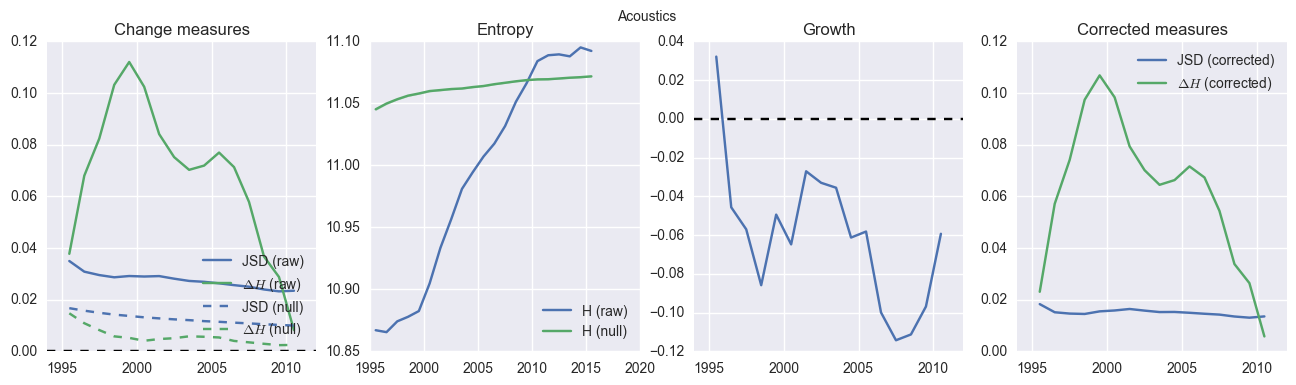

In [22]:
plotter('Acoustics',5,'local')
plotter('Acoustics',5,'global')

In [ ]:
ls ../results/

In [77]:
def normalize(arr):
    a = arr.copy()
    if a.min()<0:
        a += abs(a.min())
    a = a / a.max()
    return a

delta_h = []
g = []
for cat in tq(cats):
    df = parse_results("{}by-cat-results/results_{}_{}".format(DATADIR,window_size,cat))
    current_growth = np.mean(growth(cat,window_size))
    #if np.all(np.abs(current_growth)>0):
    delta_h += list(np.mean(df.ix['ent_difs'][0]-df.ix['entdif-null_m'][0]))
    g += list(current_growth)


TypeError: 'numpy.float64' object is not iterable

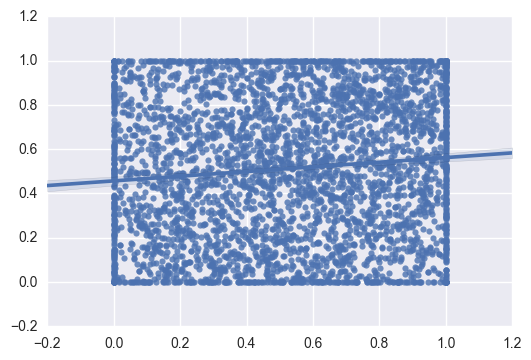

In [57]:
seaborn.regplot(x=np.array(delta_h),y=np.array(g))

In [64]:
cat_pubs_by_year['Literary Reviews'].sum()

217142.0

In [65]:
cat_pubs_by_year['Robotics'].sum()

25438.0